# Spam Detection

## About Dataset
##### Overview
The SMS Spam Collection is a dataset for SMS Spam research, featuring 5,574 English SMS messages tagged as "ham" (legitimate) or "spam." Each entry consists of two columns: (label - ham/spam) and (raw text). The dataset includes messages from various sources, such as the Grumbletext Web site, NUS SMS Corpus, Caroline Tag's PhD Thesis, and SMS Spam Corpus.

### Importing Packages

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict

In [96]:
spam_df = pd.read_csv("spam.csv", encoding='latin-1', usecols=['v1', 'v2'])
spam_df.columns = ["label", "text"]
spam_df.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [97]:
spam_df.shape

(5572, 2)

In [98]:
spam_df.drop_duplicates(inplace=True)

In [99]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5169 non-null   object
 1   text    5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [100]:
le_label = LabelEncoder()
spam_df['label'] = le_label.fit_transform(spam_df['label'])

In [101]:
spam_df.head(5)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [102]:
X = spam_df["text"]
y = spam_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [103]:
feature_extraction = TfidfVectorizer(min_df = 1, stop_words = 'english', lowercase=True)
X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [104]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_features, y_train)
y_proba = logistic_model.predict_proba(X_train_features)[:,1]
y_prediction = np.where(y_proba > 0.15, 1, 0)
accuracy = accuracy_score(y_train, y_prediction)
print(f"Accuracy on the training data = {accuracy*100:.2f}%")

Accuracy on the training data = 98.51%


In [105]:
y_proba = logistic_model.predict_proba(X_test_features)[:,1]
y_perdiction_test = np.where(y_proba > 0.15, 1, 0)
accuracy = accuracy_score(y_test, y_perdiction_test)
print(f"Accuracy on the testing data = {accuracy*100:.2f}%")

Accuracy on the testing data = 97.16%


## Building Models Pipeline

In [106]:
models = {
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)), 
        ('model', LogisticRegression())]),
    
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)), 
        ('model', MultinomialNB())]),
    
    'Support Vector Machine': Pipeline([
        ('tfidf', TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)), 
        ('model', SVC(probability=True))])
}

## Evaluating the Models

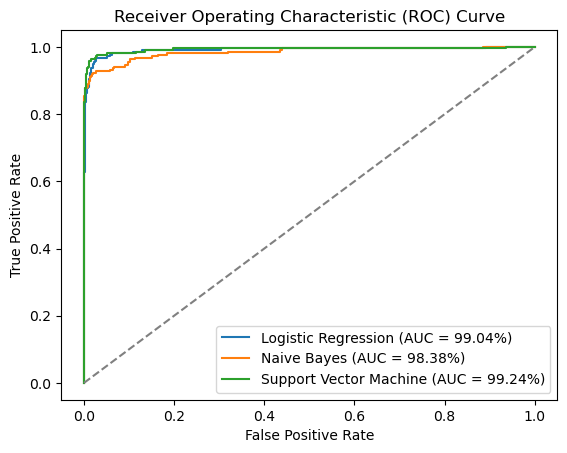

In [107]:
threshold = 0.15  # Custom threshold

for model_name, model_pipeline in models.items():
    
    model_pipeline.fit(X_train, y_train)
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
    y_prediction = np.where(y_pred_proba > threshold, 1, 0)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f}%)'.format(model_name, roc_auc*100))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


##### The Support Vector Machine model demonstrates exceptional performance with an AUC of 99.24%, showcasing its remarkable accuracy in effectively classifying instances with a high degree of precision.

In [108]:
model = models["Support Vector Machine"].fit(X, y)

In [109]:
# Save the model and vectorizer
joblib.dump(model, 'spam_model.joblib')

['spam_model.joblib']

In [110]:
# Load the model and vectorizer
loaded_model = joblib.load('spam_model.joblib')

In [111]:
y_proba = loaded_model.predict_proba(X_test)[:,1]
y_perdiction = np.where(y_proba > 0.15, 1, 0)
accuracy = accuracy_score(y_test, y_perdiction)
print(f"Accuracy = {accuracy*100:.2f}%")

Accuracy = 99.87%


In [112]:
# Function to predict spam
def predict_spam(email_text):
    proba = loaded_model.predict_proba([email_text])[:,1]
    prediction = np.where(proba > 0.15, 1, 0)
    if prediction == 1:
        result = "spam"
    else:
        result = 'ham'
    return result


####  Test the model with a spam email

In [113]:
test_email_spam = '''You have been selected for an exclusive offer to become wealthy in just days!
Our groundbreaking program guarantees massive earnings with minimal effort. 
Join thousands of satisfied customers who have transformed their lives using our system.  
Act now and gain access to our secret formula for success. 
Don't miss out on this once-in-a-lifetime opportunity! 
Click the link below to start earning big today!'''

predicted_label = predict_spam(test_email_spam)
print(f"Predicted label: {predicted_label}")

Predicted label: spam


####  Test the model with a normal email

In [114]:
test_email_ham = '''Please come prepared with your updates and any points you'd like to discuss during
the meeting. If you have any conflicts or agenda items to add, please let me know by Thursday.  
Thank you, and I look forward to our productive discussion.'''

predicted_label = predict_spam(test_email_ham)
print(f"Predicted label: {predicted_label}")

Predicted label: ham
